<a href="https://colab.research.google.com/github/Redcoder815/Deep_Learning_TensorFlow/blob/main/03SoftmaxRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

In [2]:
X = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
tf.reduce_sum(X, 0, keepdims=True), tf.reduce_sum(X, 1, keepdims=True)

(<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[5., 7., 9.]], dtype=float32)>,
 <tf.Tensor: shape=(2, 1), dtype=float32, numpy=
 array([[ 6.],
        [15.]], dtype=float32)>)

In [3]:
def softmax(X):
    X_exp = tf.exp(X)
    partition = tf.reduce_sum(X_exp, 1, keepdims=True)
    return X_exp / partition  # The broadcasting mechanism is applied here

In [4]:
X = tf.random.uniform((2, 5))
X_prob = softmax(X)
X_prob, tf.reduce_sum(X_prob, 1)

(<tf.Tensor: shape=(2, 5), dtype=float32, numpy=
 array([[0.21686164, 0.17232068, 0.14335793, 0.22240904, 0.24505071],
        [0.28909183, 0.14608505, 0.17037934, 0.15182069, 0.24262308]],
       dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([1., 1.], dtype=float32)>)

In [5]:
class SoftmaxRegressionScratch():
    def __init__(self, num_inputs, num_outputs, lr, sigma=0.01):
        # super().__init__()
        self.lr = lr
        self.W = tf.random.normal((num_inputs, num_outputs), 0, sigma)
        self.b = tf.zeros(num_outputs)
        self.W = tf.Variable(self.W)
        self.b = tf.Variable(self.b)

    def forward(self, X):
        X = tf.reshape(X, (-1, self.W.shape[0]))
        return softmax(tf.matmul(X, self.W) + self.b)

    def loss(self, y_hat, y):
        return cross_entropy(y_hat, y)

In [6]:
y_hat = tf.constant([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y = tf.constant([0, 2])
tf.boolean_mask(y_hat, tf.one_hot(y, depth=y_hat.shape[-1]))

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.1, 0.5], dtype=float32)>

In [7]:
def cross_entropy(y_hat, y):
    return -tf.reduce_mean(tf.math.log(tf.boolean_mask(
        y_hat, tf.one_hot(y, depth=y_hat.shape[-1]))))

cross_entropy(y_hat, y)

<tf.Tensor: shape=(), dtype=float32, numpy=1.497866153717041>

In [8]:
model = SoftmaxRegressionScratch(num_inputs=784, num_outputs=10, lr=0.1)

In [9]:
class SoftmaxRegressionScratch(tf.keras.Model):
    def __init__(self, num_inputs, num_outputs, lr, sigma=0.01):
        super().__init__()
        self.W = self.add_weight(name='W', shape=(num_inputs, num_outputs),
                                 initializer=tf.random_normal_initializer(stddev=sigma))
        self.b = self.add_weight(name='b', shape=(num_outputs,),
                                 initializer=tf.zeros_initializer())
        self.lr = lr

    def call(self, X):
        X = tf.reshape(X, (-1, self.W.shape[0]))
        return softmax(tf.matmul(X, self.W) + self.b)

    def loss(self, y_hat, y):
        return cross_entropy(y_hat, y)

In [11]:
import tensorflow as tf

# Load Fashion MNIST data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Preprocess data
# Reshape images to (num_samples, 784) and normalize to [0, 1]
X_train = tf.cast(tf.reshape(X_train, (-1, 784)), tf.float32) / 255.0
X_test = tf.cast(tf.reshape(X_test, (-1, 784)), tf.float32) / 255.0

# Cast labels to int64 as expected by some TF operations
y_train = tf.cast(y_train, tf.int64)
y_test = tf.cast(y_test, tf.int64)

# Hyperparameters (from original notebook context)
batch_size = 256
lr = 0.1
num_epochs = 10

# Create tf.data.Dataset objects for efficient data pipeline
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(buffer_size=1024).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)

# Instantiate the model
num_inputs = 784
num_outputs = 10
model = SoftmaxRegressionScratch(num_inputs=num_inputs, num_outputs=num_outputs, lr=lr)

# Define the accuracy metric function
def accuracy(y_hat, y):
    predicted_labels = tf.argmax(y_hat, axis=-1)
    true_labels = tf.cast(y, predicted_labels.dtype)
    correct_predictions = tf.equal(predicted_labels, true_labels)
    return tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

def custom_keras_loss(y_true, y_pred):
    y_true_int = tf.cast(y_true, tf.int32)
    return cross_entropy(y_pred, y_true_int)

# Compile the model with the optimizer, custom loss, and accuracy metric
optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
model.compile(optimizer=optimizer,
              loss=custom_keras_loss, # Use the wrapper for the custom cross_entropy
              metrics=[accuracy])

# Train the model
print(f"Training started with learning rate {lr} for {num_epochs} epochs.")
history = model.fit(train_dataset, epochs=num_epochs, validation_data=val_dataset)
print("Training finished.")

# Optional: print final validation accuracy
val_loss, val_acc = model.evaluate(val_dataset, verbose=0)
print(f"Final validation accuracy: {val_acc:.4f}")

Training started with learning rate 0.1 for 10 epochs.
Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1297 - loss: 1.0261 - val_accuracy: 0.2250 - val_loss: 0.6699
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1141 - loss: 0.5883 - val_accuracy: 0.2250 - val_loss: 0.5664
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1526 - loss: 0.5345 - val_accuracy: 0.2250 - val_loss: 0.5414
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0730 - loss: 0.5044 - val_accuracy: 0.2250 - val_loss: 0.5210
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0973 - loss: 0.4873 - val_accuracy: 0.2250 - val_loss: 0.5070
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1198 - loss: 0.4756 - val_accuracy: 0.2250 - val_loss: 0.5007
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1161 - loss: 0.4654 - val_accuracy: 0.2250 - val_loss: 0.4959
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/st

In [12]:
# Get a batch of validation data
for X, y in val_dataset.take(1):
    break

preds = tf.argmax(model(X), axis=1)
preds.shape

TensorShape([256])

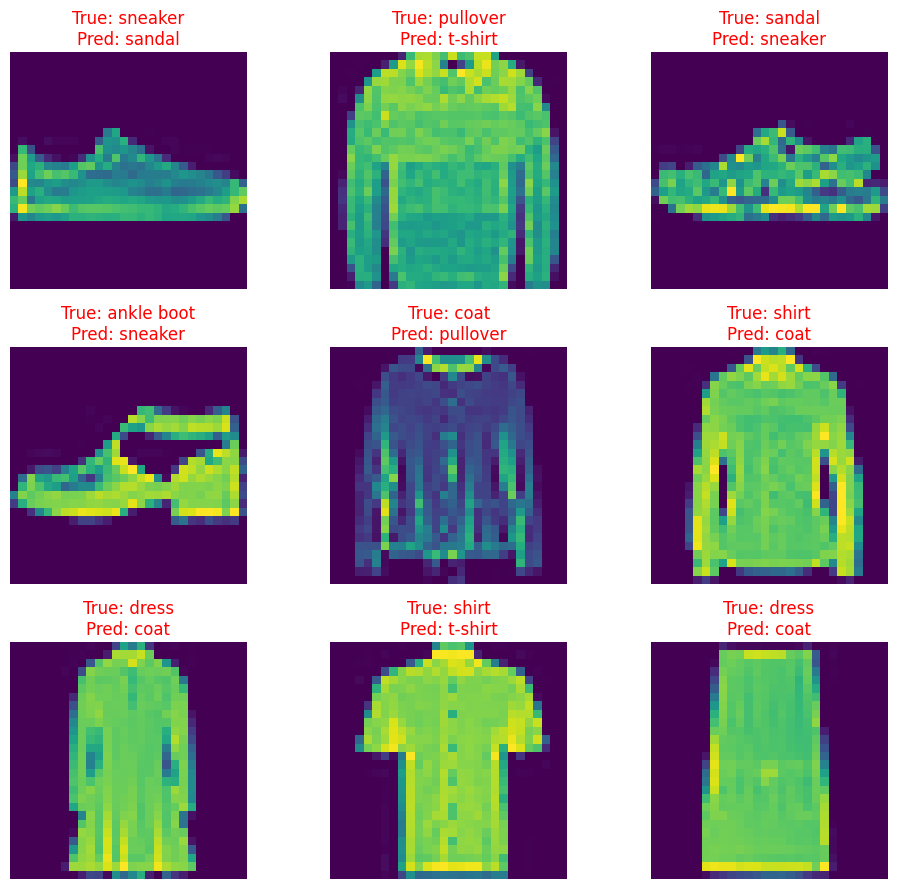

In [16]:
import matplotlib.pyplot as plt

# Define the class names for Fashion MNIST (equivalent to d2l.data.text_labels)
def get_fashion_mnist_labels(labels):
    text_labels = [
        't-shirt',
        'trouser',
        'pullover',
        'dress',
        'coat',
        'sandal',
        'shirt',
        'sneaker',
        'bag',
        'ankle boot'
    ]
    return [text_labels[int(i)] for i in labels]

wrong = tf.cast(preds, y.dtype) != y
X_wrong, y_wrong, preds_wrong = X[wrong], y[wrong], preds[wrong]

# Visualize the incorrect predictions using Matplotlib
def visualize_predictions(images, true_labels, predicted_labels, num_to_show=6):
    rows = int(num_to_show / 3) + (num_to_show % 3 > 0)
    fig, axes = plt.subplots(rows, 3, figsize=(10, rows * 3))
    axes = axes.flatten()

    for i in range(min(num_to_show, images.shape[0])):
        ax = axes[i]
        ax.imshow(tf.reshape(images[i], (28, 28)).numpy())
        true_label_text = get_fashion_mnist_labels([true_labels[i]])[0]
        predicted_label_text = get_fashion_mnist_labels([predicted_labels[i]])[0]
        ax.set_title(f"True: {true_label_text}\nPred: {predicted_label_text}",
                     color="red" if true_label_text != predicted_label_text else "black")
        ax.axis('off')

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

visualize_predictions(X_wrong, y_wrong, preds_wrong, num_to_show=9)